# GAN Tutorial 1

The aim of this tutorial is to illustrate the structure and training method for Generative Adversarial Networks (GANs), highlighting the key ideas behind GANs and elucidating the topic with a working example, using Tensorflow and Keras to train a GAN on the MNIST dataset. Familiarity with the Keras functional API as well as general knowledge of deep learning will be useful.

A GAN comprises of two separate neural networks, a Generator and a Discriminator. The objective of the generator is to produce objects that look as though they belong to any given dataset from random input. For example, we will consider the MNIST dataset in this tutorial. This dataset comprises of 28 x 28 arrays (that makes it a 784-dimensional dataset), and each array represents an image of a handwritten digit, 0-9. Each class of digit can be thought of as a manifold in 784-dimensional space, with an array lying on each manifold if and only if it is recognisable to a human as the corresponding digit. A good generator must therefore be good at mapping random inputs onto these manifolds, so that it will only generate images that look as if they belong to the true dataset.

The second network, the Discriminator, has the opposite objective. It must learn to _discriminate_ between real examples from the dataset and the 'fakes' created by the Generator. The combined structure is as follows:

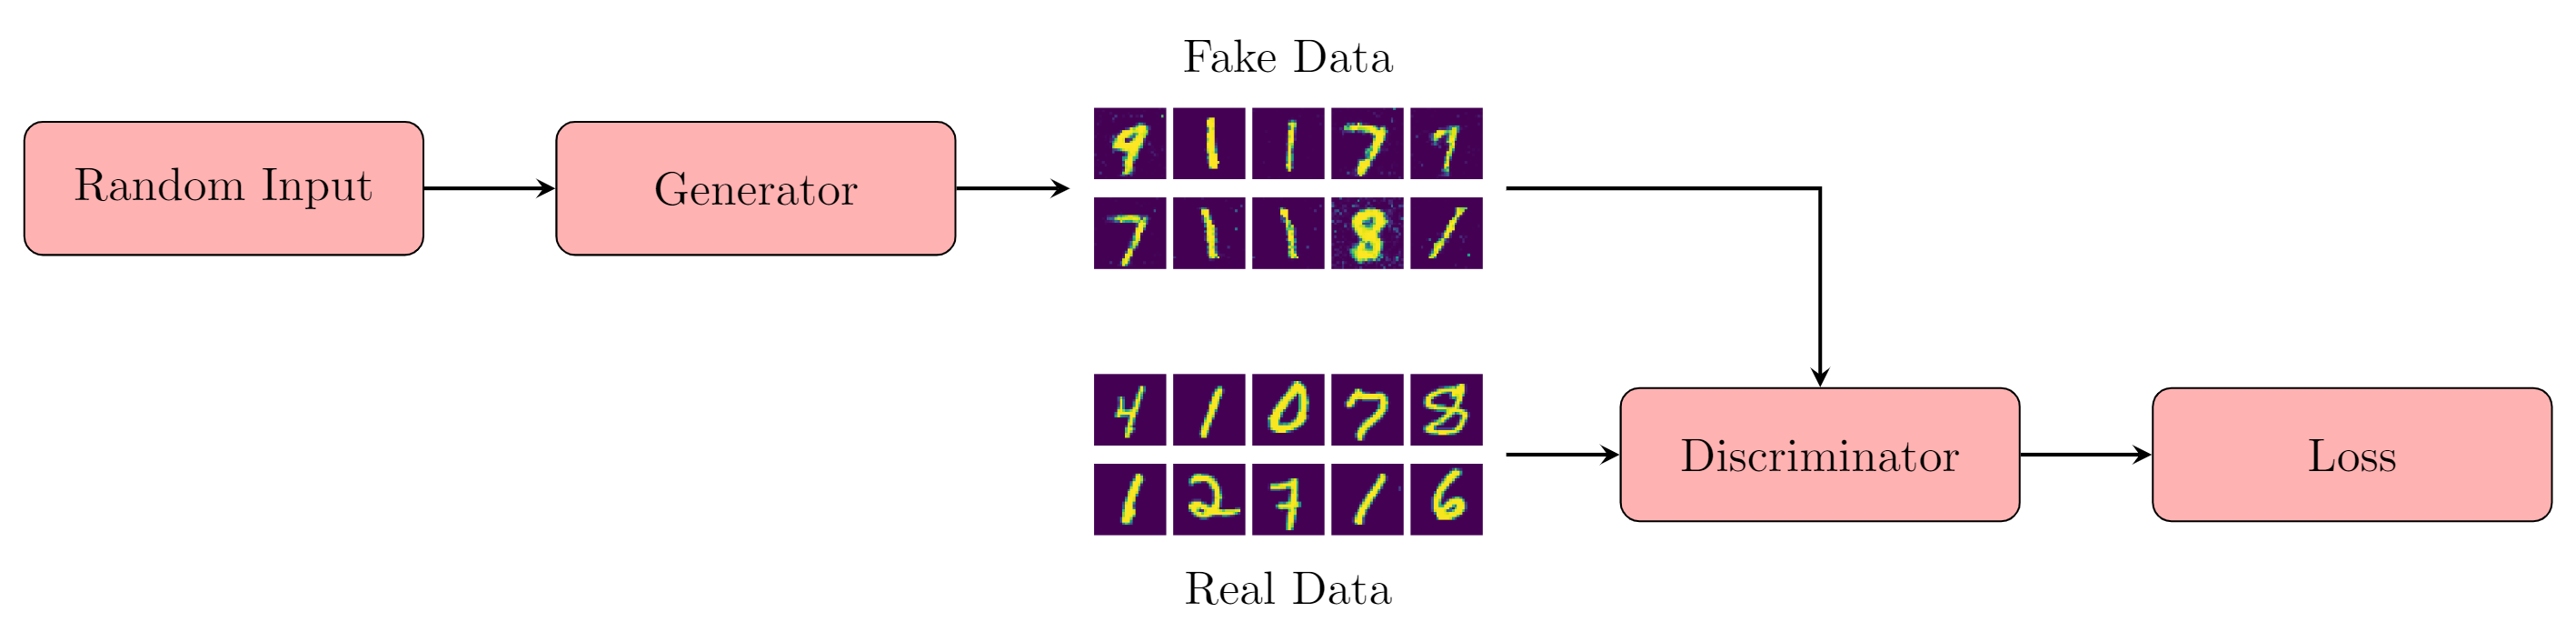

The 'Adversarial' part of the name derives from the method of training GANs. They compete (as adversaries), each trying to beat the other, and we will see how this can be achieved with Keras momentarily. It is interesting to note that the generator will never see any real data - it will simply learn how to fool the discriminator by using the gradients propagated through the discriminator via the backpropagation algorithm. For this reason GANs are particularly susceptible to the vanishing gradients problem. After all, if the gradients vanish before reaching the generator there is no way for it to learn! This is particularly important to consider when using very deep GANs, but it should not be a worry for us here.

Another common issue is that of 'Mode Collapse'. The generator can simply learn to generate the exact same thing regardless of the input. If this output is convincing, then the generator has completed its task despite being totally useless to us. 

We will consider overcoming these issues as they come up through this series of tutorials, but first we shall consider a very simple model in order to focus on understanding the training algorithm. Without further ado, let's get stuck in.

In [9]:
# Importing required modules and functions

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten 
from tensorflow.keras.optimizers import Adam 

import matplotlib.pyplot as plt
import time
import random
import tqdm
import os

Here we are setting the variables for the rest of the tutorial, if you wish to explore how different hyper-parameters affect the training, this is the place. It is particularly interesting to see how sensitive GANs are to the learning rates used, we can use different learning rates for the generator and discriminator, so tuning becomes more difficult.

In [28]:
# Setting global random seed for reproducibility
tf.random.set_seed(1234)

# MNIST is black and white, so 1 channel
IMAGE_CHANNELS = 1

# Layout for displaying generated images 
PREVIEW_ROWS = 2
PREVIEW_COLS = 5

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 100
BATCH_SIZE = 128
BUFFER_SIZE = 60000

# Optimisers
generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)

# Filepath for saving images
PATH = 'C://Users/ewand/Jupyter Projects/GAN/Output'

We are using the MNIST dataset provided by the tensorflow_datasets module. The data is loaded, the pixel values scaled to range between -1 and 1, the range of the tanh activation function which will be used in the last layer of the generator. The data is then shuffled and batched according to the BATCH_SIZE and BUFFER_SIZE parameters. We use a buffer size of 60,000 (length of the dataset) so that the data is fully shuffled, and a Batch size of 128. Batch size can be tweaked, but be mindful of available RAM, if you get an Out of Memory Error, try reducing the batch size. The prefetch(1) call means that while one batch is being used to train the network, the next batch is being loaded into memory, which can help to prevent bottle-necking. This may not be a problem for MNIST as each image has relatively little data, but can make a difference for high resolution images.

In [10]:
def scale_images(imgs):
    return 2.*tf.cast(imgs, tf.float32)/255. - 1

#Loading the data    
(mnist_train, label_train), (mnist_test, label_test) = tfds.load('mnist',
                                                                 split=['train', 'test'],
                                                                 batch_size=-1,
                                                                 as_supervised=True)
# Scale
mnist_train = scale_images(mnist_train)
# Shuffle and batch
mnist_train = tf.data.Dataset.from_tensor_slices(mnist_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

The simplicity of MNIST allows us to get to grips with GANs with a simple dense structure. We will use a generator and discriminator with 3 dense hidden layers. Since we need to generate 28 x 28 images, the final layer will have 784 units, which can then be reshaped into the desired format. The other parameters can be played with. We will also use the standard tanh activation in the last layer, with the other layers having ReLu activation for simplicity.

In [4]:
def create_generator():
    # add an input layer
    inputs = Input(shape=(SEED_SIZE,))
    
    # add the hidden layers
    x = Dense(256, activation='relu')(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(units=1024, activation='relu')(x)
    
    # add the output layer
    x = Dense(units=28*28, activation='tanh')(x)
    output = Reshape((28, 28, 1), input_shape=(28 * 28,))(x)
    
    # create the model
    generator = Model(inputs=[inputs], outputs=[output], name='Generator')
    return generator
g=create_generator()
g.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_______________________________________________

The discriminator is the mirror image of the generator. This makes sense intuitively as it is trying to undo what the generator has done. It will predict 1 for 'Real', and 0 for 'Fake', so the sigmoid activation is used in the final layer. We use ReLu in the other layers again.

In [5]:
def create_discriminator():
    # add input layer
    inputs = Input(shape=(28,28,1))
    x = Flatten()(inputs)

    # add hidden layers
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    
    # add output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    # create the model
    discriminator = Model(inputs=[inputs], outputs=[output], name='Discriminator')
    return discriminator
d =create_discriminator()
d.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
___________________________________________

Now these two networks can be combined into a GAN as if they are just layers.

In [6]:
def create_gan(discriminator, generator):
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output, name='GAN')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
Generator (Model)            (None, 28, 28, 1)         1486352   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 2,946,577
Non-trainable params: 0
_________________________________________________________________


In [7]:
# A function to plot and save example generated images from each epoch of training

def plot_generated_images(epoch, generator, noise, 
                          examples=PREVIEW_ROWS*PREVIEW_COLS, 
                          dim=(PREVIEW_ROWS, PREVIEW_COLS), 
                          figsize=(8,4)):
    
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')#, cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(PATH, f'dense_gan_generated_image {epoch}.png'))
    plt.show()

GANs can't be trained using the model.fit() method that is used for simpler deep learning models in Keras. This is because we have two different networks that must be trained concurrently, but with opposite objectives. So we must create our own training loop to iterate over the batched data:

In [ ]:
def training(epochs=100):
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    # Compiling models, 'trainable' only used when compiling, so doing it in this order means discriminator will train
    # when discriminator.train_on_batch() is called, but not when gan.train_on_batch() is called.
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer, metrics=['accuracy'])
    
    # Use fixed noise to generate example images.
    example_noise = tf.random.normal(shape=(PREVIEW_ROWS*PREVIEW_COLS, 100), mean=0, stddev=1)
    
    # Produce plots of noise from before any training occurs.
    plot_generated_images(0, generator, example_noise)
    
    for e in range(1,epochs+1): # Iterate through epochs.
        print(f'Epoch {e}')
        for batch in tqdm.notebook.tqdm(mnist_train): # Iterate through the batches, produces a nice progress bar.
            
            # Generate random noise as an input for the generator.
            noise= tf.random.normal(shape=(BATCH_SIZE, 100), mean=0, stddev=1)
            
            # Generate fake images from noise.
            generated_images = generator.predict(noise)
            
            # Construct different batches of  real and fake data.
            X = tf.concat([batch, generated_images], axis=0)
            
            # Labels for generated and real data, discriminator should map real images to 1, fakes to 0.
            # Soft labels are supposed to improve training.
            y_dis_real = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
            y_dis_fake = tf.random.uniform(shape = (BATCH_SIZE,), minval=0, maxval=0.1)
            y_dis = tf.concat([y_dis_real, y_dis_fake], axis=0)
            
            # Train discriminator on batch first. Recall discriminator.trainable was True when discriminator was compiled,
            # so the discriminator will train successfully with this call.
            discriminator.train_on_batch(X, y_dis)
            
            # Now we are going to train the generator to make the discriminator predict incorrectly, 
            # that is we want it to map the fakes to 1. We will use different random input since the previous noise was
            # used to train the discriminator.
            noise = tf.random.normal(shape = (BATCH_SIZE, 100), mean=0, stddev=1)
            y_gen = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
                        
            # Then training the GAN with noise as input and targets as real makes the generator try to 
            # trick the discriminator. This process of adversarial training will continue until the generator 
            # produces good results. Recall that the discriminator weights are frozen in this step because of the 
            # order we compiled the models.
            gan.train_on_batch(noise, y_gen)
            
        # Plot generated images at every epoch. Using the same input noise to see how the images evolve.
        plot_generated_images(e, generator, example_noise)
    return generator, discriminator
g, d = training(EPOCHS)

We see the following evolution through the epochs of training. Although we see different digits appearing throughout training, it seems to have mostly settled on drawing 1s which could be an example of mode collapse. This is where the generator learns to generate just one class from the dataset. If left to train longer, the discriminator would likely learn to classify that class as fake, at which point the generator would learn to generate another class, with this cycle continuing. Since we made no effort to prevent such behaviour, I believe we can count this result as a success, we clearly have a working training method for this class of neural network. 
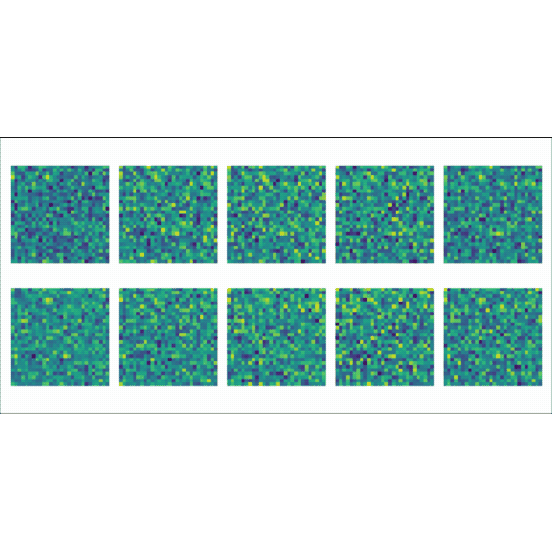
